# Dataset downloading

To run the next cell you must have Kaggle CLI installed and your API key put in the right location. Alternatively you can just download the dataset manually from here (https://www.kaggle.com/datasets/deepcontractor/is-that-santa-image-classification)

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files

In [3]:
# upload your Kaggle API key if you have it
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexfedorenko","key":"62c3ef357739462615eba070a097bdfe"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d deepcontractor/is-that-santa-image-classification
!unzip -q is-that-santa-image-classification.zip 
!rm is-that-santa-image-classification.zip 

100% 203M/203M [00:11<00:00, 20.5MB/s]
100% 203M/203M [00:11<00:00, 18.0MB/s]


In [6]:
!pip install keras_image_helper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_image_helper import create_preprocessor

Let's count files in our dataset

In [8]:
for root, dirs, files in os.walk('./is that santa/'):
    if len(files) > 0:
        print(f'{root}: {len(files)} files')

./is that santa/train/not-a-santa: 307 files
./is that santa/train/santa: 307 files
./is that santa/test/not-a-santa: 308 files
./is that santa/test/santa: 308 files


We have 616 files in testing set and 614 files in train set. The former must be split into validation and testing set

In [9]:
!mkdir './is that santa/val'
!mkdir './is that santa/val/santa'
!mkdir './is that santa/val/not-a-santa'

In [10]:
val_santa = random.sample(os.listdir('./is that santa/test/santa'), 154)
val_not_santa = random.sample(os.listdir('./is that santa/test/not-a-santa'), 154)

test_path = os.path.join(os.getcwd(), 'is that santa/test/')
val_path = os.path.join(os.getcwd(), 'is that santa/val/')

for filename in val_santa:
    shutil.move(
        os.path.join(test_path, 'santa', filename),
        os.path.join(val_path, 'santa', filename)
        )
for filename in val_not_santa:
    shutil.move(
        os.path.join(test_path, 'not-a-santa', filename),
        os.path.join(val_path, 'not-a-santa', filename)
        )

Now we will check if files were split correctly

In [11]:
for root, dirs, files in os.walk('./is that santa/'):
    if len(files) > 0:
        print(f'{root}: {len(files)} files')

./is that santa/train/not-a-santa: 307 files
./is that santa/train/santa: 307 files
./is that santa/test/not-a-santa: 154 files
./is that santa/test/santa: 154 files
./is that santa/val/not-a-santa: 154 files
./is that santa/val/santa: 154 files


# Image sets generation and preprocessing

In [12]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    './is that santa/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './is that santa/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './is that santa/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 614 images belonging to 2 classes.
Found 308 images belonging to 2 classes.
Found 308 images belonging to 2 classes.


In [13]:
train_ds.class_indices

{'not-a-santa': 0, 'santa': 1}

# Basic model training

We will use a pre-trained Xception model

In [14]:
def make_model(learning_rate=0.01):
    base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    outputs = keras.layers.Dense(1, activation='sigmoid')(vectors)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.BinaryCrossentropy()

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [15]:
model = make_model(learning_rate=0.1)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/10
20/20 [==============================] - 23s 678ms/step - loss: 2.5218 - accuracy: 0.8111 - val_loss: 1.5175 - val_accuracy: 0.9253
Epoch 2/10
20/20 [==============================] - 12s 593ms/step - loss: 0.9439 - accuracy: 0.9316 - val_loss: 0.7096 - val_accuracy: 0.9253
Epoch 3/10
20/20 [==============================] - 13s 652ms/step - loss: 0.8502 - accuracy: 0.9349 - val_loss: 2.0292 - val_accuracy: 0.8864
Epoch 4/10
20/20 [==============================] - 12s 593ms/step - loss: 0.3831 - accuracy: 0.9593 - val_loss: 0.7625 - val_accuracy: 0.9383
Epoch 5/10
20/20 [==============================] - 12s 572ms/step - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.8751 - val_accuracy: 0.9351
Epoch 6/10
20/20 [==============================] - 12s 606ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.6462 - val_accuracy: 0.9253
Epoch 7/10
20/20 [==============================] - 12s 611ms/step - loss: 9.

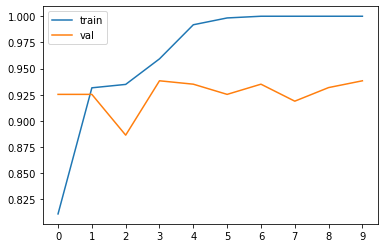

In [16]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend();

There is clear overfitting as train accuracy reached 0.93 on on the 3th epoch, so let's try a lower learning rate 

In [17]:
model = make_model(learning_rate=0.001)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
20/20 [==============================] - 16s 678ms/step - loss: 0.4506 - accuracy: 0.8192 - val_loss: 0.2833 - val_accuracy: 0.8929
Epoch 2/10
20/20 [==============================] - 12s 592ms/step - loss: 0.2589 - accuracy: 0.9104 - val_loss: 0.2214 - val_accuracy: 0.9221
Epoch 3/10
20/20 [==============================] - 12s 575ms/step - loss: 0.2078 - accuracy: 0.9251 - val_loss: 0.1958 - val_accuracy: 0.9318
Epoch 4/10
20/20 [==============================] - 12s 602ms/step - loss: 0.1746 - accuracy: 0.9495 - val_loss: 0.1734 - val_accuracy: 0.9513
Epoch 5/10
20/20 [==============================] - 12s 595ms/step - loss: 0.1487 - accuracy: 0.9560 - val_loss: 0.1617 - val_accuracy: 0.9481
Epoch 6/10
20/20 [==============================] - 12s 591ms/step - loss: 0.1327 - accuracy: 0.9691 - val_loss: 0.1534 - val_accuracy: 0.9545
Epoch 7/10
20/20 [==============================] - 12s 601ms/step - loss: 0.1170 - accuracy: 0.9739 - val_loss: 0.1503 - val_accuracy: 0.9545

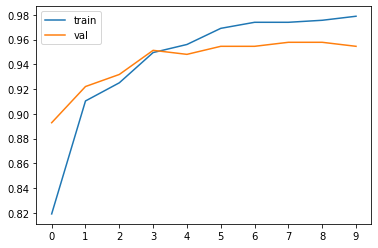

In [18]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend();

A lot better result and also higher validation accuracy. Let's try to add one inner layer and see if it improves the score

In [54]:
def make_model(learning_rate=0.001, size_inner=50):
    base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(1, activation='sigmoid')(inner)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.BinaryCrossentropy()

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [55]:
model = make_model(learning_rate=0.001, size_inner=50)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
20/20 [==============================] - 15s 612ms/step - loss: 0.3671 - accuracy: 0.8371 - val_loss: 0.2254 - val_accuracy: 0.9123
Epoch 2/10
20/20 [==============================] - 12s 577ms/step - loss: 0.1589 - accuracy: 0.9332 - val_loss: 0.1335 - val_accuracy: 0.9545
Epoch 3/10
20/20 [==============================] - 12s 613ms/step - loss: 0.0815 - accuracy: 0.9788 - val_loss: 0.1280 - val_accuracy: 0.9545
Epoch 4/10
20/20 [==============================] - 12s 574ms/step - loss: 0.0542 - accuracy: 0.9902 - val_loss: 0.1206 - val_accuracy: 0.9610
Epoch 5/10
20/20 [==============================] - 13s 651ms/step - loss: 0.0322 - accuracy: 0.9984 - val_loss: 0.1203 - val_accuracy: 0.9610
Epoch 6/10
20/20 [==============================] - 13s 617ms/step - loss: 0.0215 - accuracy: 0.9984 - val_loss: 0.1137 - val_accuracy: 0.9610
Epoch 7/10
20/20 [==============================] - 12s 615ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.1140 - val_accuracy: 0.9545

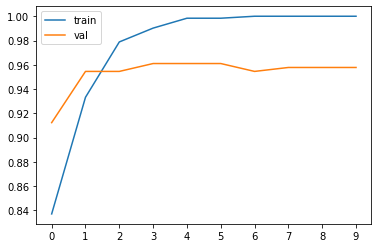

In [56]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend();

The model becomes too complex and quickly overfits. Let's add a drop layer

In [57]:
def make_model(learning_rate=0.001, size_inner=50, drop_rate=0.5):
    base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(drop_rate)(inner)
    outputs = keras.layers.Dense(1, activation='sigmoid')(drop)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.BinaryCrossentropy()

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [61]:
model = make_model(learning_rate=0.001, size_inner=50, drop_rate=0.7)
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
20/20 [==============================] - 16s 689ms/step - loss: 0.5286 - accuracy: 0.7638 - val_loss: 0.2507 - val_accuracy: 0.9188
Epoch 2/20
20/20 [==============================] - 12s 594ms/step - loss: 0.2930 - accuracy: 0.8827 - val_loss: 0.1945 - val_accuracy: 0.9253
Epoch 3/20
20/20 [==============================] - 12s 604ms/step - loss: 0.2035 - accuracy: 0.9202 - val_loss: 0.1626 - val_accuracy: 0.9383
Epoch 4/20
20/20 [==============================] - 12s 605ms/step - loss: 0.1905 - accuracy: 0.9283 - val_loss: 0.1415 - val_accuracy: 0.9448
Epoch 5/20
20/20 [==============================] - 12s 598ms/step - loss: 0.1327 - accuracy: 0.9609 - val_loss: 0.1616 - val_accuracy: 0.9351
Epoch 6/20
20/20 [==============================] - 12s 606ms/step - loss: 0.1422 - accuracy: 0.9479 - val_loss: 0.1362 - val_accuracy: 0.9351
Epoch 7/20
20/20 [==============================] - 12s 594ms/step - loss: 0.1139 - accuracy: 0.9560 - val_loss: 0.1193 - val_accuracy: 0.9578

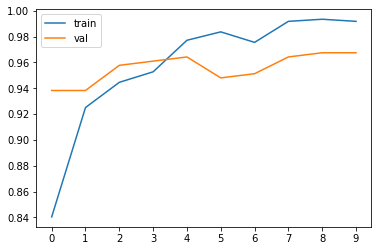

In [59]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend();

# Model performance on the test set

In [62]:
model.evaluate(test_ds)

10/10 [==============================] - 3s 244ms/step - loss: 0.0943 - accuracy: 0.9675


[0.09433410316705704, 0.9675324559211731]

We have 96% accuracy on test dataset. Let's check how the model works on an external image

In [31]:
preprocessor = create_preprocessor('xception', (150, 150))

In [32]:
!wget https://cdn.hswstatic.com/gif/santa-claus-orig.jpg

--2022-12-21 10:49:48--  https://cdn.hswstatic.com/gif/santa-claus-orig.jpg
Resolving cdn.hswstatic.com (cdn.hswstatic.com)... 18.155.68.112, 18.155.68.45, 18.155.68.44, ...
Connecting to cdn.hswstatic.com (cdn.hswstatic.com)|18.155.68.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495306 (484K) [image/jpeg]
Saving to: ‘santa-claus-orig.jpg’

santa-claus-orig.jp 100%[===================>] 483.70K   579KB/s    in 0.8s    

2022-12-21 10:49:50 (579 KB/s) - ‘santa-claus-orig.jpg’ saved [495306/495306]



In [33]:
path = './'
name = 'santa-claus-orig.jpg'
fullname = path + '/' + name
img = load_img(fullname, target_size=(150, 150))
X = preprocess_input(np.array([np.array(img)]))
pred = model.predict(X)
pred

1/1 [==============================] - 1s 1s/step


array([[0.9999988]], dtype=float32)

# Model saving

In [63]:
model.save('santa-class-v1.h5')

In [ ]:
tf.saved_model.save(model, 'santa-class-v1')

INFO:tensorflow:Assets written to: santa-class-v1/assets


INFO:tensorflow:Assets written to: santa-class-v1/assets
